In [1]:
%load_ext autoreload
%autoreload 2

In [186]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch

from dataset import LamaHDataset
from datetime import timedelta, datetime
from torch_geometric.utils import to_networkx
from tqdm import tqdm

In [188]:
def longest_path(start_id, adj):
    predecessors = list(adj[adj["NEXTDOWNID"] == start_id]["ID"])
    if not predecessors:
        return 0
    else:
        return 1 + max(longest_path(pre, adj) for pre in predecessors)

adj = pd.read_csv("LamaH-CE/processed/adjacency.csv")
gauges = list(set(adj["ID"]).union(adj["NEXTDOWNID"]))
print("Longest path length:", max(longest_path(i, adj) for i in range(900)))

Longest path length: 19


In [177]:
MAX_LAG = 48
autocorrs = pd.DataFrame(columns=range(MAX_LAG + 1))
for gauge_id in tqdm(gauges):
    gauge = pd.read_csv(f"LamaH-CE/raw/D_gauges/2_timeseries/hourly/ID_{gauge_id}.csv", sep=";")
    gauge = gauge[(gauge["YYYY"] >= 2000) & (gauge["YYYY"] <= 2017)]
    autocorrs.loc[gauge_id] = [gauge["qobs"].autocorr(lag=lag) for lag in range(MAX_LAG + 1)]

100%|██████████| 375/375 [00:45<00:00,  8.18it/s]


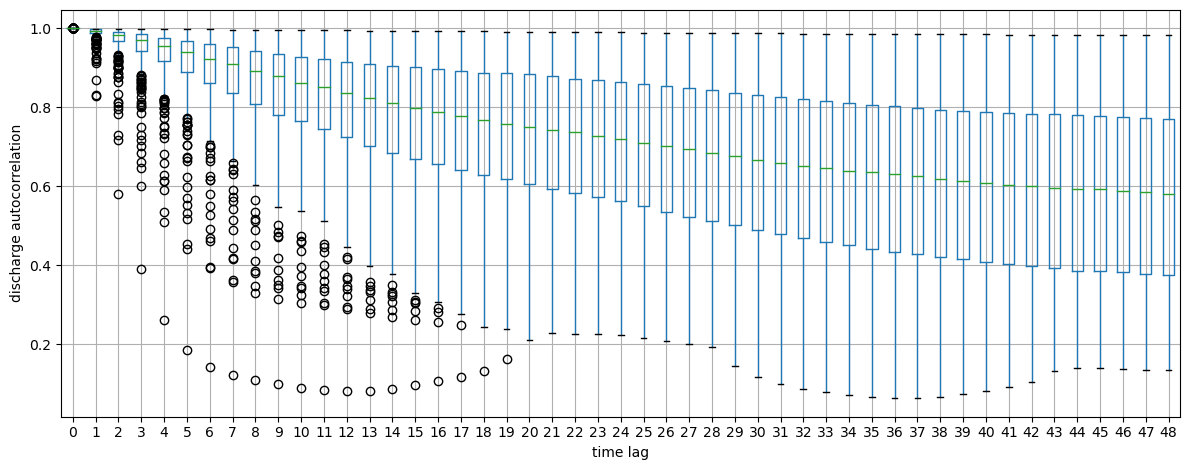

In [187]:
plt.figure(figsize=(12, 4.8))
pd.plotting.boxplot(autocorrs)
plt.xlabel("time lag")
plt.ylabel("discharge autocorrelation")
plt.tight_layout()
plt.savefig("autocorrelation.pdf")
plt.show()

In [179]:
autocorrs.idxmin()

0      37
1      85
2      85
3      85
4      85
5      85
6      85
7      85
8      85
9      85
10     85
11     85
12     85
13     85
14     85
15     85
16     85
17     85
18     85
19     85
20     85
21    398
22    398
23    398
24    398
25     78
26     78
27     78
28     85
29     85
30     85
31     85
32     85
33     85
34     85
35     85
36     85
37     85
38     85
39     85
40     85
41     85
42     85
43     85
44    169
45    169
46    169
47    169
48    169
dtype: int64

Outlier ID: 85


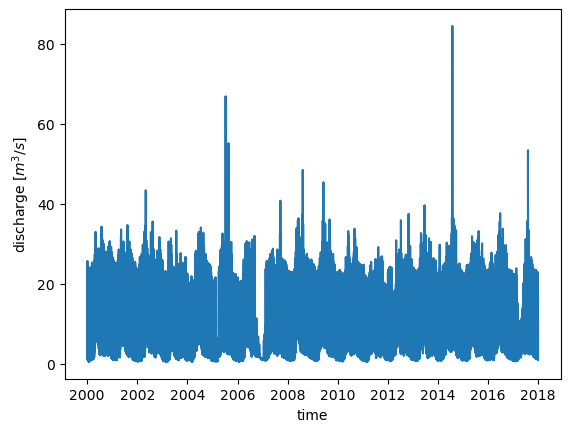

In [172]:
outlier_id = autocorrs[5].idxmin()
print("Outlier ID:", outlier_id)
gauge = pd.read_csv(f"LamaH-CE/raw/D_gauges/2_timeseries/hourly/ID_{outlier_id}.csv", sep=";")
gauge = gauge[(gauge["YYYY"] >= 2000) & (gauge["YYYY"] <= 2017)]
#gauge.loc[gauge["qobs"] > 200, "qobs"] = 200
t0 = datetime(2000, 1, 1)
t = [(t0 + timedelta(hours=i)) for i in range(len(gauge))]
plt.figure()
plt.xlabel("time")
plt.ylabel("discharge [$m^3/s$]")
plt.plot(t, gauge["qobs"])

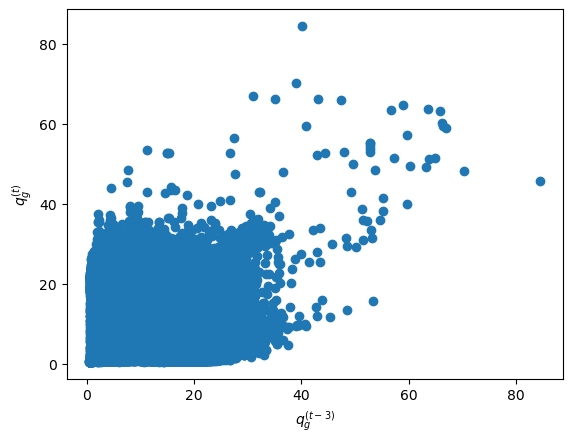

0.18472394088885205


In [173]:
pd.plotting.lag_plot(gauge["qobs"], lag=5)
plt.xlabel("$q_g^{(t-3)}$")
plt.ylabel("$q_g^{(t)}$")
plt.show()
print(gauge["qobs"].autocorr(lag=5))

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

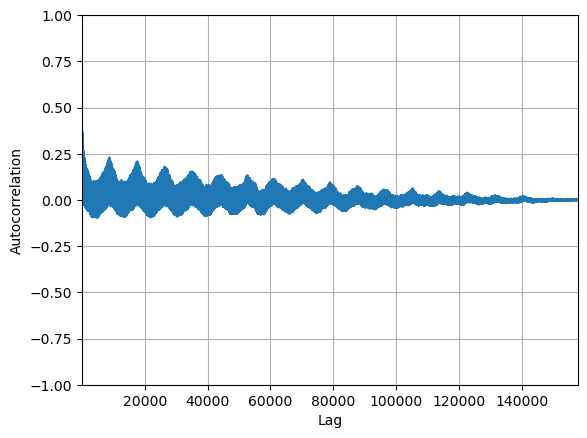

In [171]:
pd.plotting.autocorrelation_plot(gauge["qobs"])

In [185]:
dataset = LamaHDataset("LamaH-CE", years=[2000], edge_direction="bidirectional")

Loading dataset into memory...


100%|██████████| 375/375 [00:16<00:00, 23.20it/s]


In [184]:
data = dataset[0]
print("# vertices:", data.num_nodes)
print("# edges:", data.num_edges)
print("# vertex features:", data.num_node_features)
print("# edge features:", data.num_edge_features)
print("directed graph?", data.is_directed())
print("isolated vertices?", data.has_isolated_nodes())
print("self-loops?", data.has_self_loops())
print("valid?", data.validate())

# vertices: 375
# edges: 374
# vertex features: 24
# edge features: 3
directed graph? True
isolated vertices? False
self-loops? False
valid? True


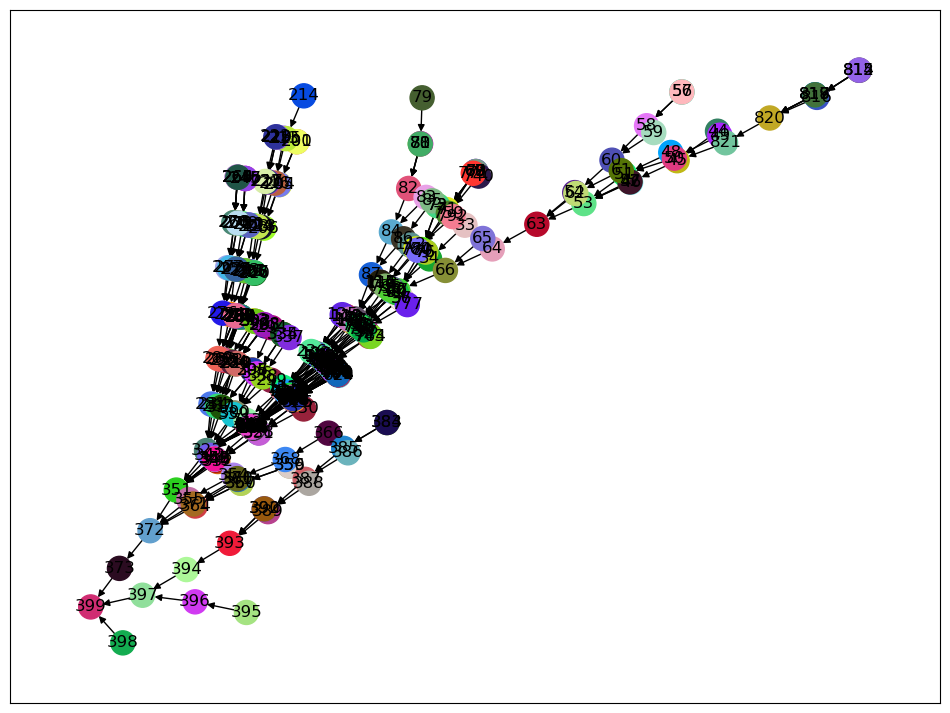

In [46]:
plt.figure(figsize=(12, 9))
graph = nx.relabel_nodes(to_networkx(data, to_undirected=False), dict(enumerate(dataset.gauges)))
nx.draw_networkx(graph, pos=nx.drawing.kamada_kawai_layout(graph), with_labels=True,
                 node_color=[tuple(torch.rand(3)) for _ in range(375)])